# Infer ***cellmask*** from the cytoplasm mask - 3️⃣
### Alternative workflow: ***"a"*** (an alternative workflow for images with NO **nuclei** or **cell membrane** makers)
--------------

## OVERVIEW
We will start by segmenting the different cell regions - the nucleus, cell, and cytoplasm - since they will be necessary for determining which organelle are in which cell. This is integral to our single cell analysis approach.

This notebook goes through the workflow steps to segment the ***cellmask*** from the cytoplasm mask generated in [01a_infer_cytoplasm_from-composite.ipynb](./01a_infer_cytoplasm_from-composite.ipynb).


## OBJECTIVE: 
### ✅ Infer sub-cellular component #3: ***cellmask***
Segment the ***cellmask*** from a composite image of multiple organelle markers combined. The ***nucleus*** mask was also derived from the cytoplasm mask in [02a_infer_nucleus_from-cytoplasm.ipynb](./02a_infer_nucleus_from-cytoplasm.ipynb). 



### IMPORTS

In [1]:
# top level imports
from pathlib import Path
import os, sys
from collections import defaultdict
from typing import Union, Tuple, List

import numpy as np

from scipy import ndimage as ndi
from aicssegmentation.core.pre_processing_utils import ( intensity_normalization, 
                                                         image_smoothing_gaussian_slice_by_slice )
from aicssegmentation.core.MO_threshold import MO
from aicssegmentation.core.utils import hole_filling

from skimage import filters
from skimage.segmentation import watershed, clear_border
from skimage.morphology import remove_small_holes, binary_dilation, binary_erosion 
from skimage.measure import label

# # package for io 
from aicsimageio import AICSImage

import napari

### import local python functions in ../infer_subc
sys.path.append(os.path.abspath((os.path.join(os.getcwd(), '..'))))


from infer_subc.core.file_io import (read_czi_image,
                                     read_ome_image,
                                     import_inferred_organelle,
                                     export_inferred_organelle,
                                     list_image_files)

                                             
from infer_subc.core.img import *
from infer_subc.organelles import (get_nuclei, 
                                   get_cytoplasm,
                                   non_linear_cellmask_transform,
                                   choose_max_label_cellmask_union_nucleus)


%load_ext autoreload
%autoreload 2

## Get and load Image for processing

In [2]:
test_img_n = 0

data_root_path = Path(os.path.expanduser("~")) / "Documents/Python Scripts/Infer-subc-2D"

in_data_path = data_root_path / "neuron_raw_OME"
im_type = ".tiff"

img_file_list = list_image_files(in_data_path,im_type)
test_img_name = img_file_list[test_img_n]

out_data_path = data_root_path / "neuron_raw_OME_out-06012023"
if not Path.exists(out_data_path):
    Path.mkdir(out_data_path)
    print(f"making {out_data_path}")

In [3]:
img_data,meta_dict = read_czi_image(test_img_name)

channel_names = meta_dict['name']
img = meta_dict['metadata']['aicsimage']
scale = meta_dict['scale']
channel_axis = meta_dict['channel_axis']

c:\Users\Shannon\anaconda3\envs\infer-subc\lib\site-packages\ome_types\_convenience.py:112: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


---------
## infer ***cellmask*** from cytoplasm mask

### summary of steps

➡️ INPUT
- segmented cytoplasm object (from [01a_infer_cytoplasm_from-composite.ipynb](./01a_infer_cytoplasm_from-composite.ipynb))
- segmented nucleus object (from [02a_infer_nucleus_from-cytoplasm.ipynb](./02a_infer_nucleus_from-cytoplasm.ipynb))

PRE-PROCESSING

CORE-PROCESSING
- logical **OR** of the nucleus and cytoplasm

POST-PROCESSING
- fill small holes (hole size = user input)

OUTPUT ➡️ 
- save labeled ***cellmask*** (cell, CM) as unsigned integer 16-bit tif files

## EXTRACT prototype

In [4]:
###################
# INPUT
###################
cytoplasm_mask = import_inferred_organelle("cyto",meta_dict, out_data_path)
nucleus_mask = import_inferred_organelle("nuc",meta_dict, out_data_path)

loaded  inferred 3D `cyto`  from C:\Users\Shannon\Documents\Python Scripts\Infer-subc-2D\neuron_raw_OME_out-06012023 
loaded  inferred 3D `nuc`  from C:\Users\Shannon\Documents\Python Scripts\Infer-subc-2D\neuron_raw_OME_out-06012023 


## PRE-PROCESSING prototype

No preprocessing steps are required.

## CORE PROCESSING prototype

In [5]:
###################
# CORE_PROCESSING
###################
cell = np.logical_or(nucleus_mask, cytoplasm_mask)

## POST PROCESSING prototype

In [6]:
###################
# POST_PROCESSING
###################
min_hole_width = 0
max_hole_width = 30
small_obj_width = 0
fill_method = "3D"

cleaned_img = fill_and_filter_linear_size(cell, 
                                          hole_min=min_hole_width, 
                                          hole_max=max_hole_width, 
                                          min_size=small_obj_width, 
                                          method=fill_method)

## LABELING prototype

In [7]:
###################
# LABELING
###################
# create instance segmentation based on connectivity
cell_mask = label_bool_as_uint16(cleaned_img)

In [8]:
cell_mask.dtype

dtype('uint16')

## Visualize with `napari` 1
Visualize the first-pass segmentation and labeling with `napari`.

In [9]:
viewer = napari.Viewer()

In [10]:
viewer.add_image(
    cytoplasm_mask,
    opacity=0.3)

viewer.add_image(
    nucleus_mask,
    opacity=0.3,
    colormap='blue')

viewer.add_image(
    cell_mask,
    opacity=0.3,
    colormap='bop orange')

<Image layer 'cell_mask' at 0x1fd48393580>

## SAVE inferred cellmask to .tif file


In [11]:
out_file_n = export_inferred_organelle(cell_mask, "cell", meta_dict, out_data_path)

saved file: 20221027_C2-107_well_1_cell_1_untreated_Linear_unmixing_decon.ome-cell


----------
## DEFINE `infer_cellmask_fromcytoplasm` function

Based on the _prototyping_ above define the function to infer nuclei. 

> NOTE: these functions mainly serve for downstream prototyping in the notebooks. Each step above has an independent function that is implemented in the plugin for easy of use.

In [12]:
##########################
#  _infer_nuclei
##########################
def _infer_cellmask_fromcytoplasm(cytoplasm_mask: np.ndarray,
                                  nucleus_mask: np.ndarray,
                                  min_hole_width: int,
                                  max_hole_width: int,
                                  small_obj_width: int,
                                  fill_method: str
                                  ) -> np.ndarray:
    """
    Procedure to infer 3D nuclei segmentation from multichannel z-stack input.

    Parameters
    ------------
    cytoplasm_mask: np.ndarray
        3D image containing the mask of the cytoplasm
    nucleus_mask: np.ndarray
        3D image containing the mask of the nucleus
    min_hole_width: int
        minimum size of holes to fill in final cell mask
    max_hole_width: int,
        maximum size of holes to fill in final cell mask
    small_obj_w: int
        minimum object size cutoff to remove from final cell mask; likely not required since small objects were removed from cytoplasm mask
    fill_method: str
        method for fill and filter; either "3D" or "slice_by_slice"

    Returns
    -------------
    cell_mask
        mask defined extent of the entire cell
    
    """

    ###################
    # CORE_PROCESSING
    ###################
    cell = np.logical_or(nucleus_mask, cytoplasm_mask)

    ###################
    # POST_PROCESSING
    ###################
    cleaned_img = fill_and_filter_linear_size(cell, 
                                              hole_min=min_hole_width, 
                                              hole_max=max_hole_width, 
                                              min_size=small_obj_width, 
                                              method=fill_method)

    ###################
    # LABELING
    ###################
    cell_mask = label_bool_as_uint16(cleaned_img)

    return cell_mask


## DEFINE `_fixed_infer_cellmask_fromcytoplasm` function

Based on the _prototyping_ above define the function to infer cellmask. with a *fixed* set of parameters for each step in the procedure.  That is they are all "hard coded"

In [13]:
##########################
#  fixed_infer_nuclei_fromcytoplasm
##########################
def _fixed_infer_cellmask_fromcytoplasm(cytoplasm_mask: np.ndarray,
                                        nucleus_mask:np.ndarray) -> np.ndarray:
    """
    Procedure to infer cellmask from the cytoplasm mask

    Parameters
    ------------
    in_img: np.ndarray
        a 3d image containing cytoplasm segmentation
 
    Returns
    -------------
    nuclei_object
        inferred nuclei
    
    """
    min_hole_w = 0
    max_hole_w = 30
    small_obj_w = 0
    fill_filter_method = "3D"

    return _infer_cellmask_fromcytoplasm(cytoplasm_mask,
                                         nucleus_mask,
                                         min_hole_w,
                                         max_hole_w,
                                         small_obj_w,
                                         fill_filter_method)


## TEST `_infer_cellmask_fromcytoplasm`  function defined above

In [14]:
_CM_object =  _fixed_infer_cellmask_fromcytoplasm(cytoplasm_mask, nucleus_mask) 

_CM_object.dtype

dtype('uint16')

In [15]:
np.all(cell_mask == _CM_object)

True

---------------------
# TEST `infer_cellmask_fromcytoplasm` exported functions

The prototype `_infer_cellmask_fromcytoplasm` was copied to the [`.organelles.cellmask`](../infer_subc/organelles/cellmask.py) sub-module.

In [16]:
from infer_subc.organelles.cellmask import fixed_infer_cellmask_fromcytoplasm
cell_object =  fixed_infer_cellmask_fromcytoplasm(cytoplasm_mask, nucleus_mask) 

cell_object.dtype

dtype('uint16')

In [17]:
np.all(_CM_object == cell_object)

True

## Visualize  2


In [18]:
viewer.add_image(
    _CM_object,
    opacity=0.3)

viewer.add_image(
    cell_object,
    opacity=0.3)

<Image layer 'cell_object' at 0x1fd6f87f850>

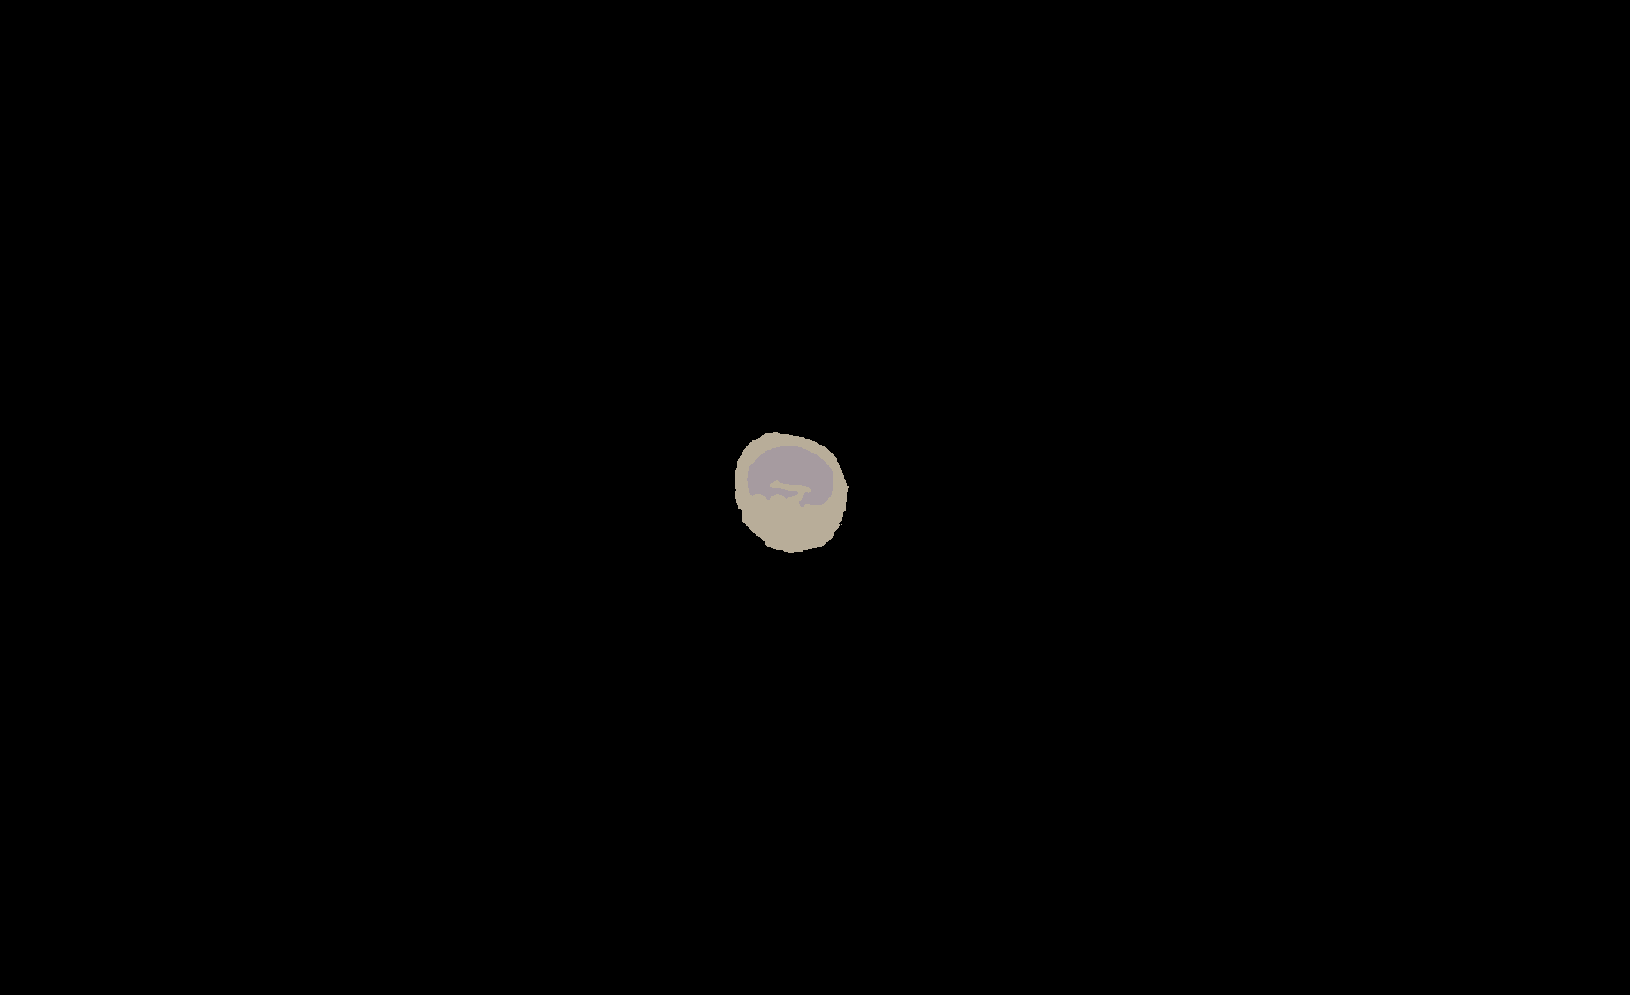

In [19]:
from napari.utils.notebook_display import nbscreenshot

nbscreenshot(viewer, canvas_only=True)

In [20]:
viewer.close()

-------------
## SUMMARY

The above explains the general procedure for segmenting the cell mask from the cytoplasm mask.

### NEXT: INFER LYSOSOMES

proceed to [05_infer_lysosomes.ipynb](./05_infer_lysosome.ipynb)
